## 1. NumPy, Pandas, TensorFlow ve Keras gibi kütüphaneler kullanıldı ve görüntü verileri ile çalışmak için altyapı hazırlandı.


In [42]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

direc = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Sea Bass
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Striped Red Mullet
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Striped Red Mullet
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Sea Bass
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Gilt-Head Bream


## 2.⁠ ⁠Bu kod, görüntü verisini incelemek ve etiketlerle birlikte görselleştirmek için kullanıldı.

Index(['FilePaths', 'Labels'], dtype='object')


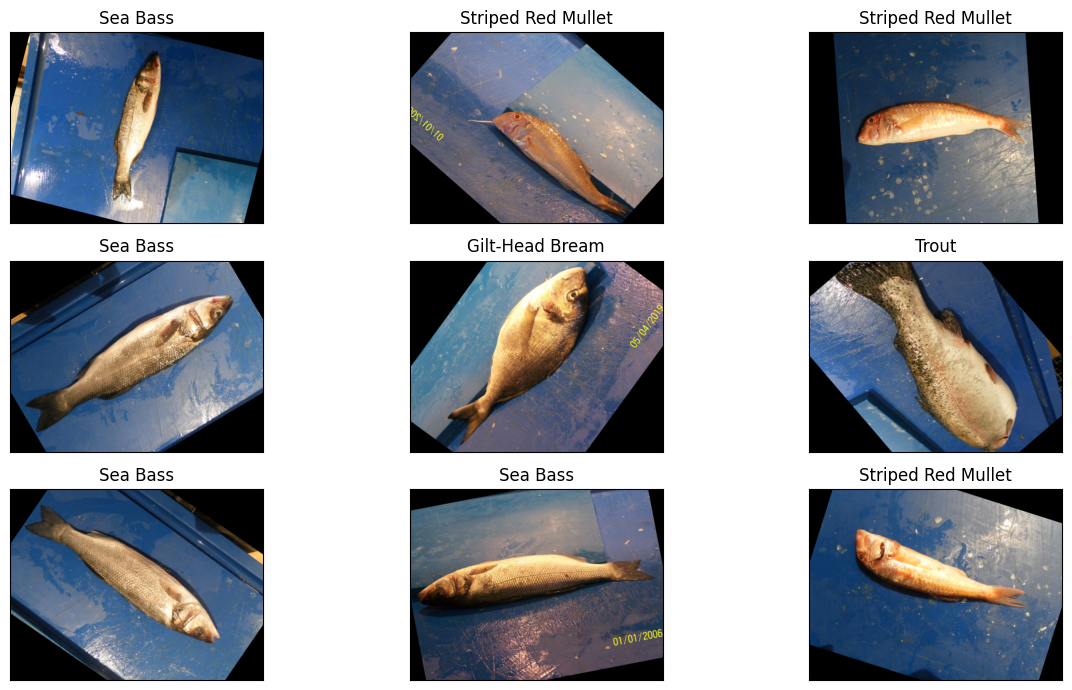

In [43]:
import matplotlib.pyplot as plt

# DataFrame'deki sütun adlarını kontrol et
print(img_df.columns)  # Sütun adlarını kontrol et

# Görüntüleri göster
f, a = plt.subplots(nrows=3, ncols=3, figsize=(13, 7),
                     subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df['FilePaths'].iloc[i]))  # Sütun adını güncelledik
    ax.set_title(img_df['Labels'].iloc[i])  # Sütun adını güncelledik

plt.tight_layout()
plt.show()

## 3.Pandas DataFrame'inin satır ve sütun sayısını göstermek için kullanıldı.



In [44]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


## 4.DataFrame'indeki "Labels" sütunundaki etiketlerin her birinin kaç kez tekrarlandığını saymak için kullanıldı.



In [45]:
img_df['Labels'].value_counts(ascending=True)

Labels
Sea Bass              1000
Striped Red Mullet    1000
Gilt-Head Bream       1000
Trout                 1000
Red Mullet            1000
Black Sea Sprat       1000
Red Sea Bream         1000
Shrimp                1000
Hourse Mackerel       1000
Name: count, dtype: int64

## 5.⁠ ⁠Veriyi düzenli bir şekilde ayırmak amacıyla kullanıldı. Ayrıca, test verisinin korunması, model değerlendirmesinde tutarlılık sağlaması amaçlandı.


In [46]:
from sklearn.model_selection import train_test_split

train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15

# Eğitim ve test setlerini ayır
x_train, x_temp = train_test_split(img_df, test_size=1 - train_ratio)

# Kalan veriyi doğrulama ve test setleri olarak ayır
x_val, x_test = train_test_split(x_temp, test_size=test_ratio / (test_ratio + validation_ratio))

# Şekilleri kontrol et
print(f'Shape of Training Data: {x_train.shape}')  # Eğitim verisinin boyutu
print(f'Shape of Validation Data: {x_val.shape}')  # Doğrulama verisinin boyutu
print(f'Shape of Testing Data: {x_test.shape}')     # Test verisinin boyutu

# x_test'in bir kopyasını oluştur
x_testt = x_test.copy()

Shape of Training Data: (6750, 2)
Shape of Validation Data: (900, 2)
Shape of Testing Data: (1350, 2)


## 6.Bu Python kodu, görüntü verilerini hazırlamak ve eğitim, test, doğrulama setleri için akış (flow) olarak almak için kullanıldı.


In [47]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


## 7.Bu Python kodu, Keras kullanarak bir yapay sinir ağı (YSA) modeli oluşturdu.Modelin amacı, 224x224 piksel boyutunda ve 3 renk kanalı (RGB) olan görüntüleri alarak bunları 9 farklı sınıfa sınıflandırmaktır.


In [48]:
from tensorflow.keras.layers import Input

fc_model = tf.keras.models.Sequential([
  Input(shape=(224, 224, 3)),  # Doğru boyut: 224x224 piksel, 3 renk kanalı
  tf.keras.layers.Rescaling(1./255),  # Normalizasyon katmanı
  tf.keras.layers.Flatten(),  # Düzleştirme katmanı
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9, activation="softmax")  # 9 sınıf için softmax
])

## 9. fc_model yapay sinir ağı modelini derler ve eğitir


In [50]:
# Modeli derle
from keras.callbacks import EarlyStopping
fc_model.compile(optimizer="adam", 
                 loss="categorical_crossentropy", 
                 metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modeli eğit
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                      validation_data=x_val,
                      epochs=10, 
                      callbacks=[early_stopping])
                       

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 123s 562ms/step - accuracy: 0.4646 - loss: 1.4637 - val_accuracy: 0.7100 - val_loss: 0.8671
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 140s 552ms/step - accuracy: 0.6669 - loss: 0.9241 - val_accuracy: 0.8111 - val_loss: 0.5936
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 119s 552ms/step - accuracy: 0.7816 - loss: 0.6373 - val_accuracy: 0.8533 - val_loss: 0.4306
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 119s 552ms/step - accuracy: 0.8430 - loss: 0.4565 - val_accuracy: 0.8933 - val_loss: 0.3048
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 121s 557ms/step - accuracy: 0.8780 - loss: 0.3496 - val_accuracy: 0.9156 - val_loss: 0.2541
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 125s 577ms/step - accuracy: 0.9049 - loss: 0.2718 - val_accuracy: 0.9356 - val_loss: 0.1936
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 124s 576ms/step - accuracy: 0.9268 - loss: 0.2168 - val_accuracy: 0.9289 - val_loss: 0.2204
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 124s 572ms/step - accuracy: 0.9365 -

## 10. Bu bilgi, modelin uygun olup olmadığını değerlendirmek, aşırı karmaşık olup olmadığını görmek veya modeldeki katmanların doğru bir şekilde tanımlandığını kontrol etmek için kullanıldı ve modelin eğitimine başlamadan katmanların doğruluğunu kontrol etmek için kullanıldı.

In [52]:
print('Model summary :')
print()
fc_model.summary()

Model summary :



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,856,157 (220.70 MB)

 Trainable params: 19,285,385 (73.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,570,772 (147.14 MB)

## 11. Bu kod parçasının amacı, modelin test veri seti üzerindeki doğruluğunu (accuracy) değerlendirmektir.

In [53]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - accuracy: 0.9469 - loss: 0.1465
Test accuracy is :  94.44444179534912 %


## 12. Bu kod parçasının amacı, modelin eğitim sürecindeki performansını görselleştirmektir. Eğitim ve doğrulama doğruluğu ile kaybını (loss) grafikler üzerinden göstererek, modelin nasıl öğrendiğini ve genel eğilimleri anlamayı sağlar.1.NumPy, Pandas, TensorFlow ve Keras gibi kütüphaneler kullanıldı ve görüntü verileri ile çalışmak için altyapı hazırlandı.


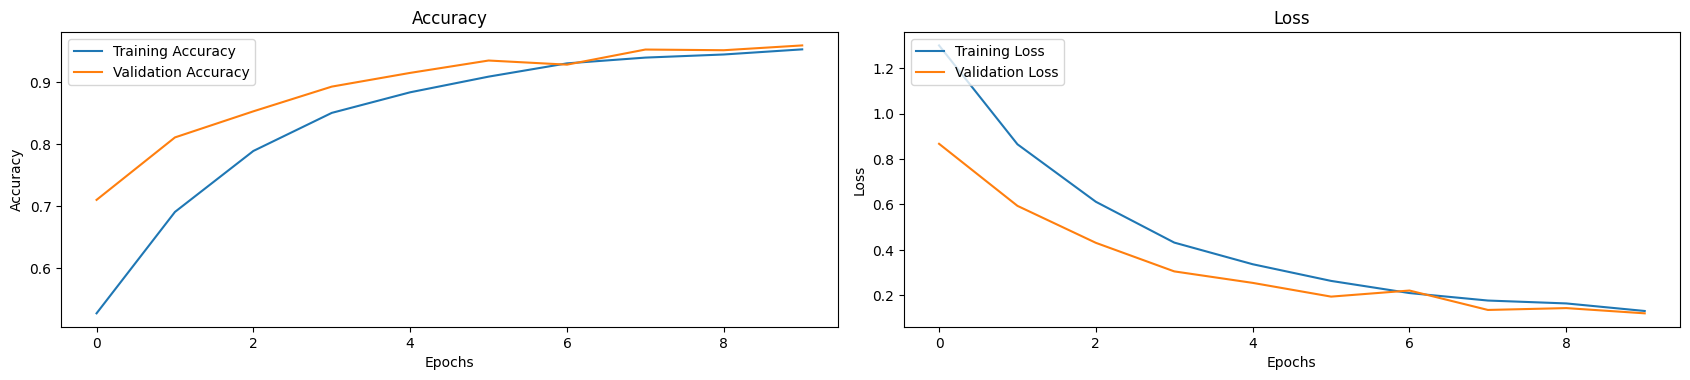

In [54]:

# Modelin egitim gecmisi
history = mo_fit.history

# Anahtar isimlerini kontrol ederek grafik cizimi
accuracy = history.get('accuracy', [])
validation_accuracy = history.get('val_accuracy', [])
loss = history.get('loss', [])
validation_loss = history.get('val_loss', [])

# Grafik cizimi
plt.figure(figsize=(17, 7))

# Dogruluk grafigi
plt.subplot(2, 2, 1)
if accuracy and validation_accuracy:
    plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
    plt.plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
else:
    print("Accuracy veya Validation Accuracy verileri eksik!")

# Kayip grafigi
plt.subplot(2, 2, 2)
if loss and validation_loss:
    plt.plot(range(len(loss)), loss, label='Training Loss')
    plt.plot(range(len(validation_loss)), validation_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
else:
    print("Loss veya Validation Loss verileri eksik!")

plt.tight_layout()
plt.show()